# Setup

## Libraries

In [1]:
library(MASS)
library(class)
library(randomForest)
library(caret)
library(e1071)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin



## Read Data

In [2]:
Ldata = read.csv("data/train.csv")
Ldata.features = Ldata[ , -c(1, 2)]
TrainIDs = Ldata[, 1]
TrLabels = Ldata[, 2]
Ldata = Ldata[, -1]

In [3]:
TLdata = read.csv("data/test.csv")
TestIDs = TLdata[, 1]
TLdata = TLdata[, -1]
TsLabels = TrLabels[1:nrow(TLdata)]
Labels = unlist(list(TrLabels, TsLabels))

In [4]:
numTrainPoints = nrow(Ldata)
numTestPoints = nrow(TLdata)
numPoints = numTrainPoints + numTestPoints

## Helper Functions

In [5]:
log_loss <- function(class, prob){
    class.ind = prob
    for (i in 1:nrow(prob)) {
        class.ind[i, class[i]] = 1
    }
    class.ind[class.ind != 1] = 0
    return(-sum(class.ind * log(prob))/nrow(prob))
}

In [6]:
rescale <- function(prob){
    for (i in 1:nrow(prob)) {
        prob[i,] = prob[i,]/sum(prob[i,])
    }
    return(prob)
}

# Explore Data

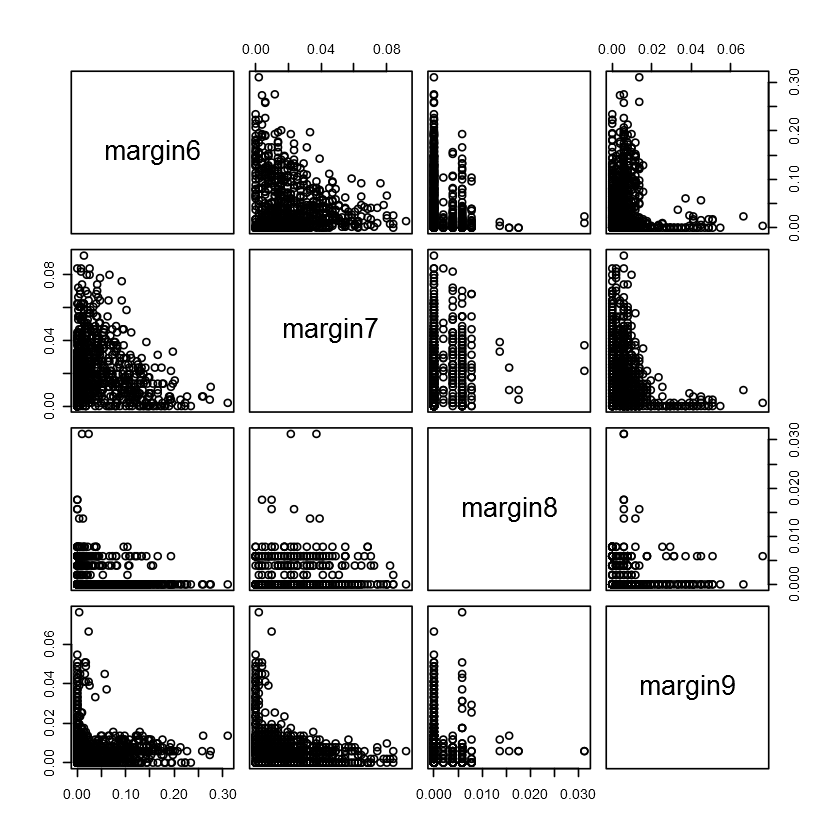

In [7]:
pairs(Ldata[7:10])

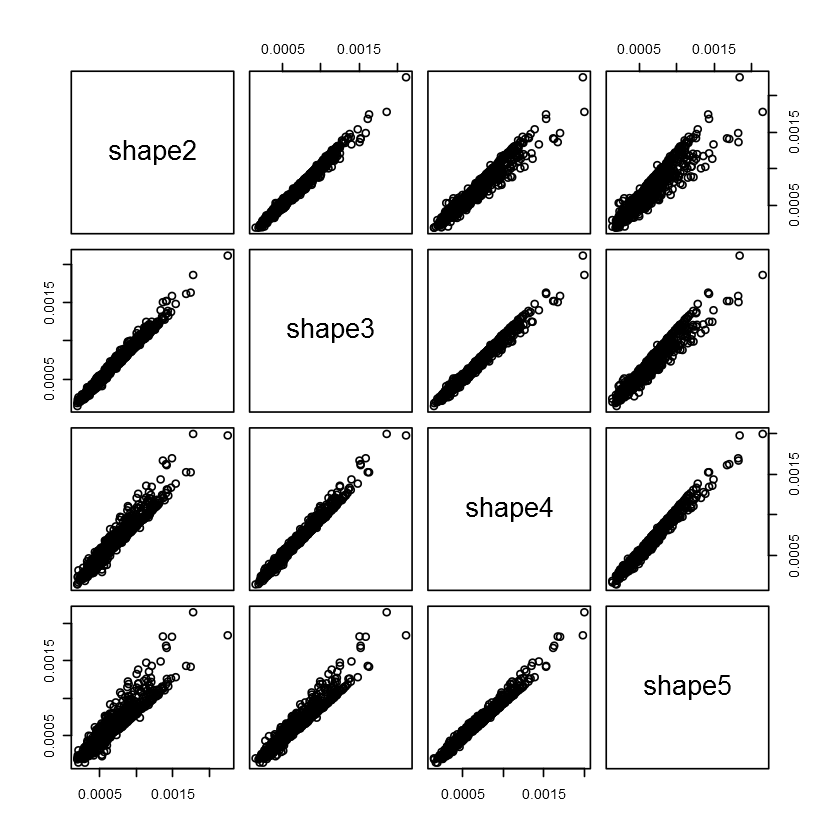

In [8]:
pairs(Ldata[67:70])

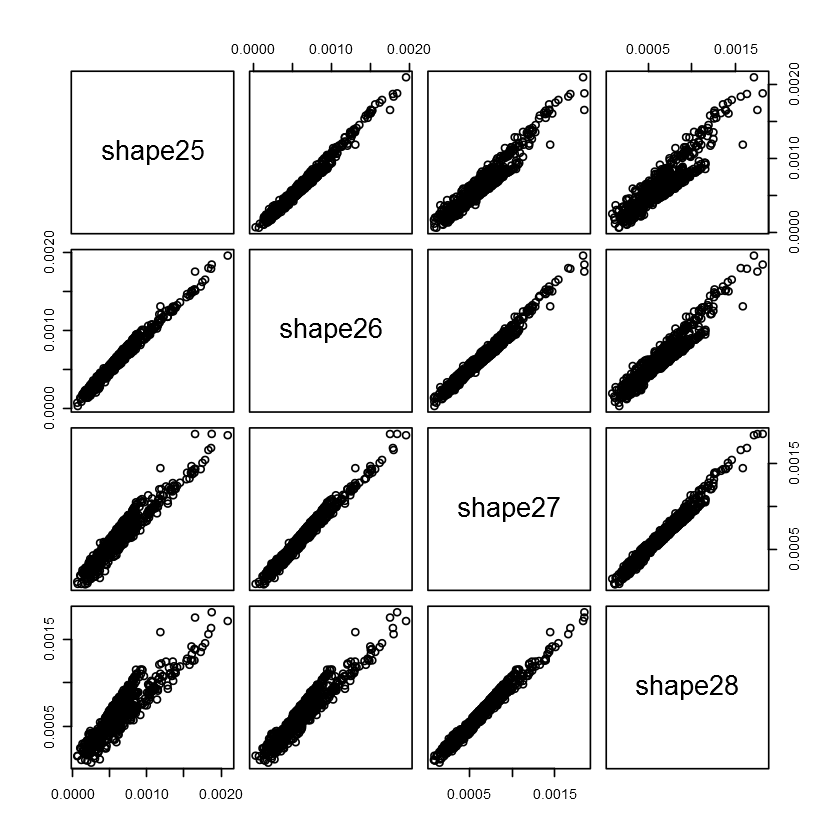

In [9]:
pairs(Ldata[90:93])

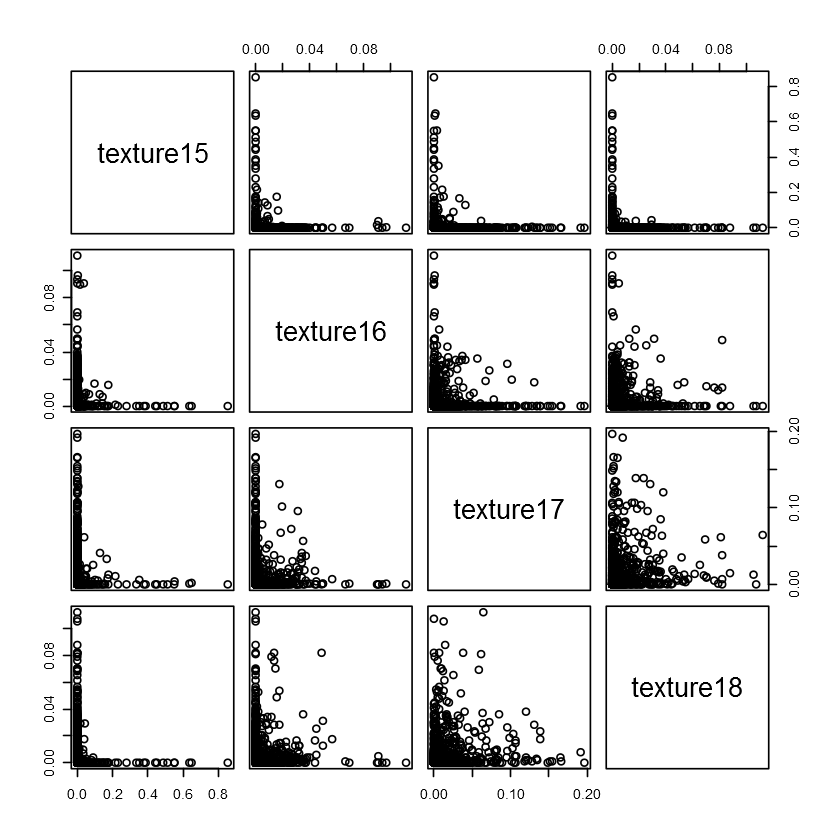

In [10]:
pairs(Ldata[144:147])

## Principal Components

In [11]:
Full.features = scale(rbind(Ldata.features, TLdata))

In [12]:
Full.prc = princomp(Full.features)

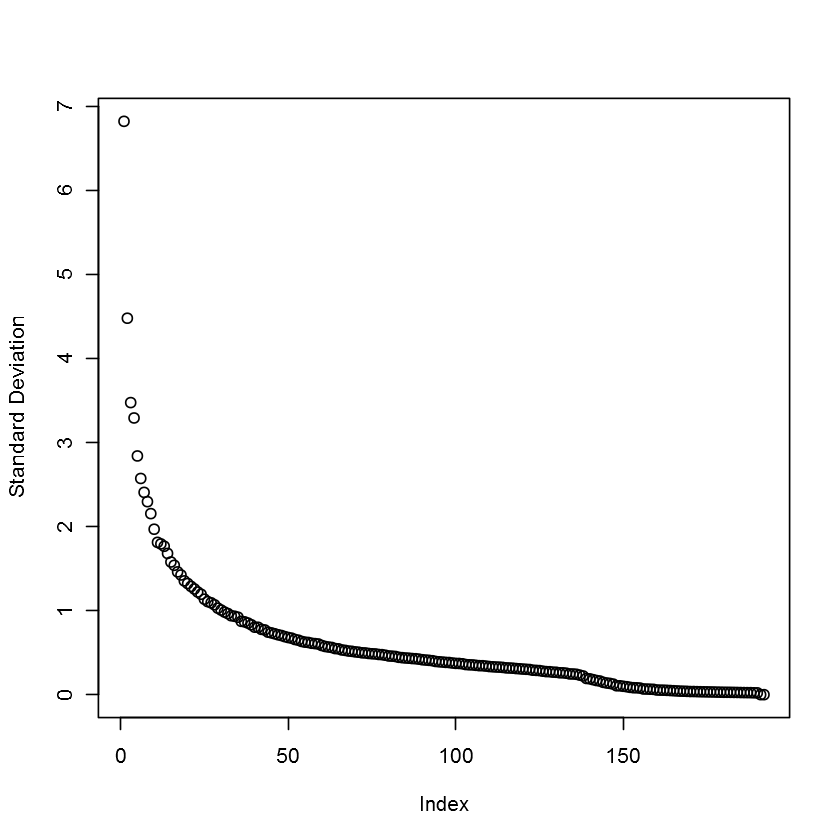

In [14]:
plot(Full.prc$sdev, ylab='Standard Deviation')

## Feature Plots

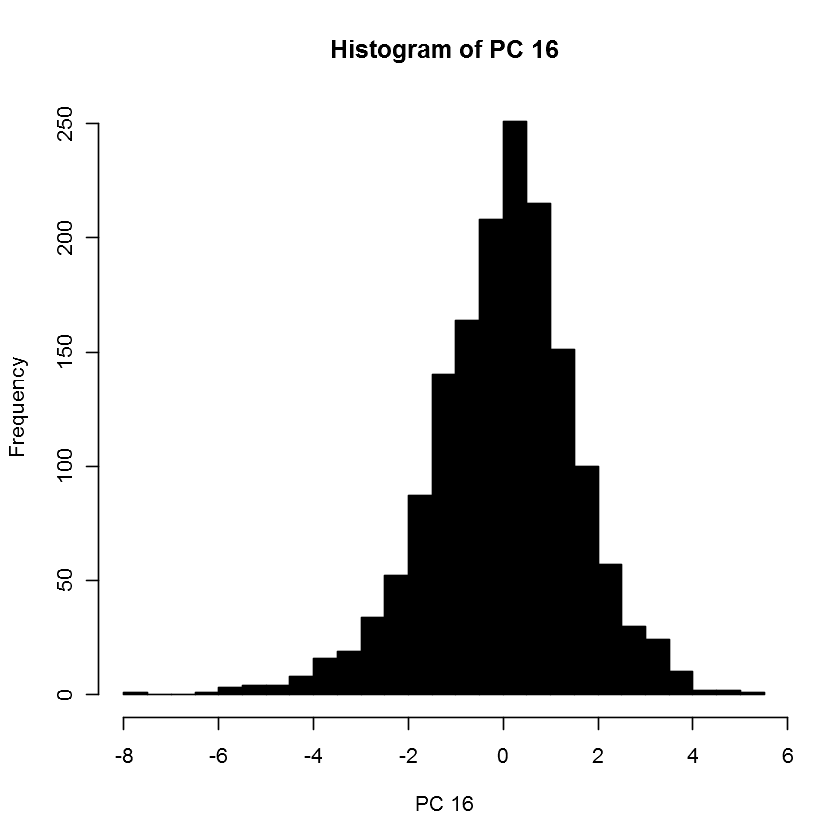

In [13]:
hist(Full.prc$scores[, "Comp.16"], breaks=40, col="black",
     main='Histogram of PC 16',
     xlab='PC 16'
    )

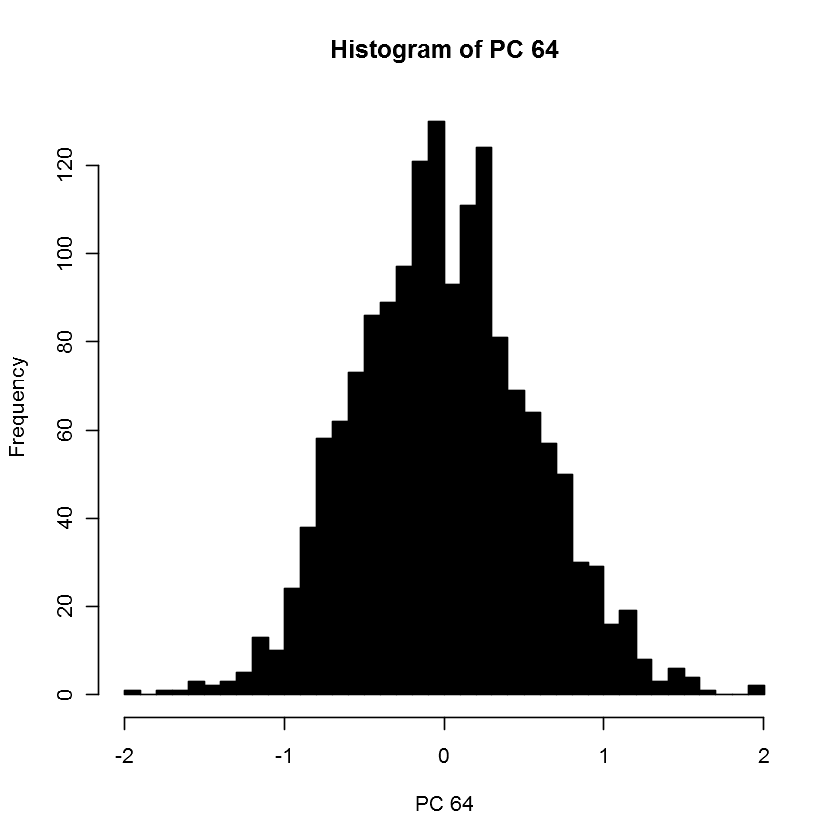

In [15]:
hist(Full.prc$scores[, "Comp.64"], breaks=40, col="black",
     main='Histogram of PC 64',
     xlab='PC 64'
    )

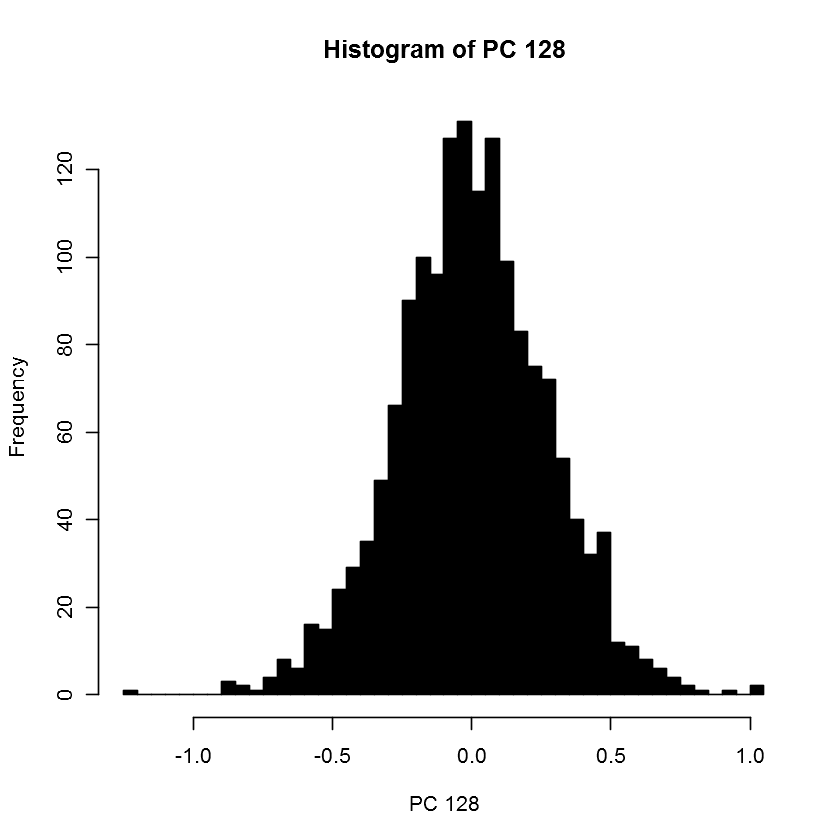

In [16]:
hist(Full.prc$scores[, "Comp.128"], breaks=40, col="black",
     main='Histogram of PC 128',
     xlab='PC 128'
    )

# Split Data

In [17]:
numComps = 154
df = data.frame(Labels, Full.prc$scores[, 1:numComps])
tr = 1:numTrainPoints
Full.prc.train <- df[tr, ]
Full.prc.test <- df[-tr, ]

In [18]:
frac = 0.1
test = sample(numTrainPoints, round(numTrainPoints*frac))

In [19]:
test.X  = Full.prc.train[test, ]
train.X = Full.prc.train[-test, ]
test.Y  = Full.prc.train$Labels[test]
train.Y = Full.prc.train$Labels[-test]

In [20]:
X = Full.prc.train
Y = X$Labels
T = Full.prc.test

In [21]:
epsilon = 1e-220

# Naive Bayes

In [22]:
nb.fit = naiveBayes(Labels~., X)

In [23]:
nb.tr.prob = predict(nb.fit, newdata = X, type='raw')

In [24]:
nb.tr.class = predict(nb.fit, newdata = X, type='class')

In [25]:
nb.tr.prob[nb.tr.prob < epsilon] = epsilon
nb.tr.prob[nb.tr.prob == 1] = 1-epsilon
nb.tr.prob = rescale(nb.tr.prob)

In [26]:
# Training Accuracy
mean(nb.tr.class == Y)

[1] 1

In [27]:
# Training Log Loss
log_loss(nb.tr.class, nb.tr.prob)

[1] 1.525155e-17

# LDA

In [28]:
lda.fit = lda(Labels ~ ., data=train.X)

In [29]:
lda.tr.class = predict(lda.fit, train.X[,-1])$class
lda.tr.pred = predict(lda.fit, train.X[,-1], type="response")
lda.tr.prob = lda.tr.pred$posterior
#predict(lda.fit, test.X)$class

In [30]:
lda.tr.prob[lda.tr.prob < epsilon] = epsilon
lda.tr.prob[lda.tr.prob == 1] = 1-epsilon
lda.tr.prob = rescale(lda.tr.prob)

In [31]:
# Training Accuracy
mean(lda.tr.class == train.Y)

[1] 0.9988777

In [32]:
# Training Log-loss
log_loss(lda.tr.class, lda.tr.prob)

[1] 2.31857e-11

In [33]:
lda.cv.class = predict(lda.fit, test.X)$class
lda.cv.pred = predict(lda.fit, test.X, type="response")
lda.cv.prob = lda.cv.pred$posterior

In [34]:
lda.cv.prob[lda.cv.prob < epsilon] = epsilon
lda.cv.prob[lda.cv.prob == 1] = 1-epsilon
lda.cv.prob = rescale(lda.cv.prob)

In [35]:
# Cross Validation Accuracy
mean(lda.cv.class == test.Y)

[1] 0.969697

In [36]:
# Cross Validation Log-loss
log_loss(test.Y, lda.cv.prob)

[1] 0.416761

# k-NN

## 1-NN

In [37]:
# Training Accuracy
knn.pred.k1 = knn(train.X[,-1], train.X[,-1], train.Y, k=1)
mean(knn.pred.k1 == train.Y)

[1] 1

In [38]:
# Testing Accuracy
knn.pred.k1 = knn(train.X[,-1], test.X[,-1], train.Y, k=1)
mean(knn.pred.k1 == test.Y)

[1] 0.979798

## 3-NN

In [39]:
# Training Accuracy
knn.pred.k3 = knn(train.X[,-1], train.X[,-1], train.Y, k=3)
mean(knn.pred.k3 == train.Y)

[1] 0.9887767

In [40]:
# Cross Validation Accuracy
knn.pred.k3 = knn(train.X[,-1], test.X[,-1], train.Y, k=3)
mean(knn.pred.k3 == test.Y)

[1] 0.969697

## 5-NN

In [43]:
# Training Accuracy
knn.pred.k5 = knn(train.X[,-1], train.X[,-1], train.Y, k=5)
mean(knn.pred.k5 == train.Y)

[1] 0.9809203

In [44]:
# Cross Validation Accuracy
knn.pred.k5 = knn(train.X[,-1], test.X[,-1], train.Y, k=5)
mean(knn.pred.k5 == test.Y)

[1] 0.9494949

## 7-NN

In [41]:
# Training Accuracy
knn.pred.k7 = knn(train.X[,-1], train.X[,-1], train.Y, k=7)
mean(knn.pred.k7 == train.Y)

[1] 0.9809203

In [42]:
# Cross Validation Accuracy
knn.pred.k7 = knn(train.X[,-1], test.X[,-1], train.Y, k=7)
mean(knn.pred.k7 == test.Y)

[1] 0.9494949

## 32-NN

In [45]:
# Training Accuracy
knn.pred.k32 = knn(train.X[,-1], train.X[,-1], train.Y, k=32)
mean(knn.pred.k32 == train.Y)

[1] 0.7542088

In [46]:
# Cross Validation Accuracy
knn.pred.k32 = knn(train.X[,-1], test.X[,-1], train.Y, k=32)
mean(knn.pred.k32 == test.Y)

[1] 0.5656566

# Random Forests

In [47]:
fitControl <- trainControl(## 10-fold CV
                           method = "cv",
                           #number = 6,
                           #repeats = 3,
                           #search = "grid"
                          )
mtry = round(sqrt(numComps))
numtry = 6
metric = "Accuracy"
tunegrid = expand.grid(.mtry=sample.int(mtry, size = numtry))

In [48]:
rf.fit = train(Labels ~ .,
               data = X, 
               method = "rf",
               metric = metric,
               allowParallel=TRUE,
               trControl = fitControl,
               tuneGrid=tunegrid
               )

In [49]:
print(rf.fit)

Random Forest 

990 samples
154 predictors
 99 classes: 'Acer_Capillipes', 'Acer_Circinatum', 'Acer_Mono', 'Acer_Opalus', 'Acer_Palmatum', 'Acer_Pictum', 'Acer_Platanoids', 'Acer_Rubrum', 'Acer_Rufinerve', 'Acer_Saccharinum', 'Alnus_Cordata', 'Alnus_Maximowiczii', 'Alnus_Rubra', 'Alnus_Sieboldiana', 'Alnus_Viridis', 'Arundinaria_Simonii', 'Betula_Austrosinensis', 'Betula_Pendula', 'Callicarpa_Bodinieri', 'Castanea_Sativa', 'Celtis_Koraiensis', 'Cercis_Siliquastrum', 'Cornus_Chinensis', 'Cornus_Controversa', 'Cornus_Macrophylla', 'Cotinus_Coggygria', 'Crataegus_Monogyna', 'Cytisus_Battandieri', 'Eucalyptus_Glaucescens', 'Eucalyptus_Neglecta', 'Eucalyptus_Urnigera', 'Fagus_Sylvatica', 'Ginkgo_Biloba', 'Ilex_Aquifolium', 'Ilex_Cornuta', 'Liquidambar_Styraciflua', 'Liriodendron_Tulipifera', 'Lithocarpus_Cleistocarpus', 'Lithocarpus_Edulis', 'Magnolia_Heptapeta', 'Magnolia_Salicifolia', 'Morus_Nigra', 'Olea_Europaea', 'Phildelphus', 'Populus_Adenopoda', 'Populus_Grandidentata', 'Populus_Nig

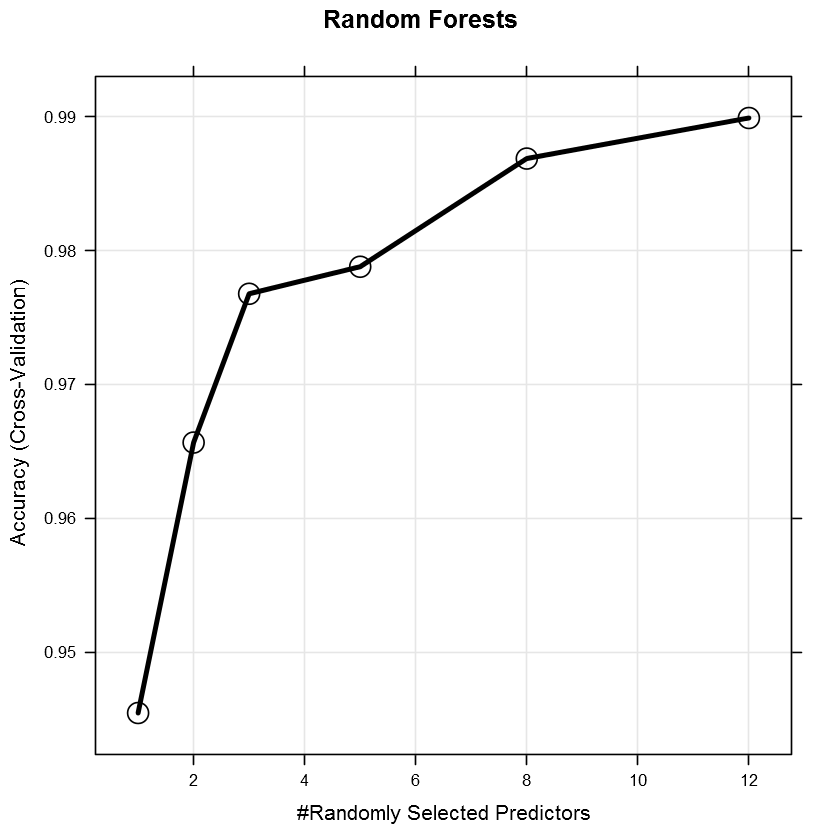

In [50]:
plot(rf.fit, cex = 2.0, lwd = 3.0, col="black", main = "Random Forests")

In [51]:
rf.tr.prob = predict(rf.fit, newdata = X, type = "prob")
rf.tr.class = predict(rf.fit, newdata = X, type = "raw")

In [52]:
rf.tr.prob[rf.tr.prob < epsilon] = epsilon
rf.tr.prob[rf.tr.prob == 1] = 1-epsilon
rf.tr.prob = rescale(rf.tr.prob)

In [53]:
# Training Accuracy
mean(rf.tr.class == Y)

[1] 1

In [54]:
# Training Log Loss
log_loss(rf.tr.class, data.matrix(rf.tr.prob))

[1] 0.2898068